In [17]:
import time
import psutil
import os
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
import csv
from scipy.stats import kruskal, mannwhitneyu
import pandas as pd
import subprocess
import cProfile
import pstats
import threading
import matplotlib.pyplot as plt

In [18]:
class BENCHMARK_VQSVD():
    def __init__(self, script_paths):
        self.script_paths = script_paths  # Lista de scripts a correr
        self.results = {os.path.basename(p): [] for p in script_paths}
        self.all_profiles = []
        self.df_sorted = None

    def monitor_cpu(self, pid, usage_list, interval=0.1):
        try:
            proc = psutil.Process(pid)
            while proc.is_running():
                usage = proc.cpu_percent(interval=interval)
                usage_list.append(usage)
        except psutil.NoSuchProcess:
            pass

    def monitor_ram(self, pid, usage_list, interval=0.1):
        try:
            proc = psutil.Process(pid)
            while proc.is_running():
                usage = proc.memory_info().rss / 1024**2
                usage_list.append(usage)
                time.sleep(interval)
        except psutil.NoSuchProcess:
            pass

    def run_script_and_measure(self, path_to_script, profile_output_path=None):
        print(f"Running: {path_to_script}")
        start_time = time.time()
        cpu_usages = []
        ram_usages = []

        cmd = ["python", "-m", "cProfile", "-o", profile_output_path, path_to_script] if profile_output_path else ["python", path_to_script]
        proc = subprocess.Popen(cmd,stdout=subprocess.DEVNULL)#,stderr=subprocess.DEVNULL)

        cpu_thread = threading.Thread(target=self.monitor_cpu, args=(proc.pid, cpu_usages))
        ram_thread = threading.Thread(target=self.monitor_ram, args=(proc.pid, ram_usages))
        cpu_thread.start()
        ram_thread.start()

        proc.wait()
        cpu_thread.join()
        ram_thread.join()

        end_time = time.time()

        return {
            "source": os.path.basename(path_to_script),
            "wall_time": end_time - start_time,
            "cpu_percent": sum(cpu_usages) / len(cpu_usages) if cpu_usages else 0,
            "ram_used_mb": max(ram_usages) if ram_usages else 0,
            "profile_path": profile_output_path if profile_output_path else None
        }

    def run_benchmark(self, iterations):
        for i in range(iterations):
            print(f"\n--- RUN {i+1} ---")
            for script in self.script_paths:
                name = os.path.basename(script)
                profile_path = f"Output/profile/profile_{name.replace('.py','')}_run{i+1}.prof"
                result = self.run_script_and_measure(script, profile_output_path=profile_path)
                self.results[name].append(result)

        self.save_results_to_csv()
        self.save_profile_to_csv(iterations)

    def load_profile_to_dataframe(self, profile_path,name):
        stats = pstats.Stats(profile_path)
        stats_data = []

        for func, stat in stats.stats.items():           
                file_name, line_no, func_name = func
                cc, nc, tt, ct, callers = stat
                if file_name == name:
                    stats_data.append({
                        "file": file_name,
                        "line": line_no,
                        "function": func_name,
                        "ncalls": nc,
                        "tottime": tt,
                        "cumtime": ct
                    })

        return pd.DataFrame(stats_data)

    def save_profile_to_csv(self, iterations):
        for script in self.script_paths:
            name = os.path.basename(script)
            backend = name.replace(".py", "")
            for i in range(iterations):
                path = f"Output/profile/profile_{backend}_run{i+1}.prof"
                if os.path.exists(path):
                    df = self.load_profile_to_dataframe(path,name)
                    df["backend"] = backend
                    df["run"] = i + 1
                    self.all_profiles.append(df)

        df_all_profiles = pd.concat(self.all_profiles, ignore_index=True)
        self.df_sorted = df_all_profiles.sort_values(by="cumtime", ascending=False)
        self.df_sorted.to_csv("Output/all_profiles_sorted.csv", index=False)



    def save_results_to_csv(self):
        all_results = []
        for script_name, res_list in self.results.items():
            for res in res_list:
                res["source"] = script_name
                all_results.append(res)
        df = pd.DataFrame(all_results)
        df.to_csv("Output/vqsvd_results.csv", index=False)

    def get_results(self):
        return self.results

    def get_df_sorted(self):
        return self.df_sorted


In [19]:

scripts = ["solution_clean_paddle.py","solution_clean_pennylane.py"] ##  
benchmark = BENCHMARK_VQSVD(scripts)
benchmark.run_benchmark(iterations=1)  # puedes cambiar el número de iteraciones si quieres



--- RUN 1 ---
Running: solution_clean_paddle.py


/usr/local/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/usr/local/lib/python3.8/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/usr/local/lib/python3.8/site-packages/paddle/fluid/framework.py:1104: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itse

Running: solution_clean_pennylane.py


/usr/local/lib/python3.8/site-packages/pennylane_lightning/lightning_qubit/lightning_qubit.py:822: UserWarning: Pre-compiled binaries for lightning.qubit are not available. Falling back to using the Python-based default.qubit implementation. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.
  warn(


Averages Pennylane:
wall_time      340.989551
cpu_percent    101.859110
ram_used_mb    574.132812
dtype: float64
Averages Paddle:
wall_time       11.764813
cpu_percent    141.878448
ram_used_mb    799.300781
dtype: float64


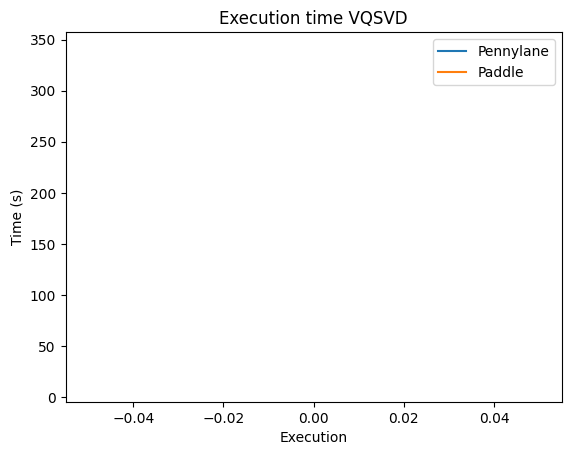

In [20]:
results = benchmark.get_results()
df = pd.DataFrame([entry for script_results in results.values() for entry in script_results])
df_penny = df[df["source"] == "solution_clean_pennylane.py"].reset_index(drop=True)
df_paddle = df[df["source"] == "solution_clean_paddle.py"].reset_index(drop=True)

print("Averages Pennylane:")
print(df_penny[["wall_time", "cpu_percent", "ram_used_mb"]].mean())

print("Averages Paddle:")
print(df_paddle[["wall_time", "cpu_percent", "ram_used_mb"]].mean())

# Plot time
plt.plot(df_penny["wall_time"], label="Pennylane")
plt.plot(df_paddle["wall_time"], label="Paddle")
plt.ylabel("Time (s)")
plt.xlabel("Execution")
plt.title("Execution time VQSVD")
plt.legend()
plt.show()

In [42]:
# Carga el CSV de resultados
input_file = "Output/all_profiles_sorted.csv"

filtered = pd.read_csv(input_file)

grouped = df.groupby(['file', 'function'], as_index=False).agg(
    ncalls=('ncalls', 'sum'),
    tottime=('tottime', 'mean'),
    cumtime=('cumtime', 'mean')
)
pivot_ncalls = grouped.pivot(index='function', columns='file', values='ncalls').add_suffix('_ncalls')
pivot_tottime = grouped.pivot(index='function', columns='file', values='tottime').add_suffix('_tottime')
pivot_cumtime = grouped.pivot(index='function', columns='file', values='cumtime').add_suffix('_cumtime')
result = pivot_ncalls.join([pivot_tottime, pivot_cumtime], how='outer').fillna(0)

pd.set_option('display.float_format', '{:.8f}'.format)
result


file,solution_clean_paddle.py_ncalls,solution_clean_pennylane.py_ncalls,solution_clean_paddle.py_tottime,solution_clean_pennylane.py_tottime,solution_clean_paddle.py_cumtime,solution_clean_pennylane.py_cumtime
function,,,,,,
<lambda>,0.00000000,10.00000000,0.00000000,0.00002458,0.00000000,185.46890464
<listcomp>,0.00000000,1345.00000000,0.00000000,0.00058089,0.00000000,0.00058220
<module>,1.00000000,1.00000000,0.03080791,0.00020915,11.00454766,339.94509779
Mat_generator,2.00000000,2.00000000,0.00005230,0.00005638,0.00017078,0.00015426
U_theta,2.00000000,0.00000000,0.00008502,0.00000000,0.03274792,0.00000000
VQSVD,1.00000000,1.00000000,0.00000346,0.00000472,0.00000346,0.00000472
__init__,1.00000000,1.00000000,0.00000875,0.00004035,0.03288684,8.18893681
_basis_circuit,0.00000000,1344.00000000,0.00000000,0.01221296,0.00000000,24.04043037
ansatz,0.00000000,1344.00000000,0.00000000,0.56619630,0.00000000,23.92295025


Kruskal–Wallis

In [21]:
# Comparisons between Paddle and Pennylane

kw_wall_time = kruskal(
    df_paddle["wall_time"],
    df_penny["wall_time"]
)
kw_cpu = kruskal(
    df_paddle["cpu_percent"],
    df_penny["cpu_percent"]
)
kw_ram = kruskal(
    df_paddle["ram_used_mb"],
    df_penny["ram_used_mb"]
)

print("Kruskal–Wallis test results:")
print(f"Wall time p-value: {kw_wall_time.pvalue}")
print(f"CPU % p-value:     {kw_cpu.pvalue}")
print(f"RAM used p-value:  {kw_ram.pvalue}")


Kruskal–Wallis test results:
Wall time p-value: 0.31731050786291115
CPU % p-value:     0.31731050786291115
RAM used p-value:  0.31731050786291115


Post-hoc – Mann–Whitney U (p < 0.05)

In [22]:
mw_wall = mannwhitneyu(
    df_paddle["wall_time"],
    df_penny["wall_time"],
    alternative="two-sided"
)
mw_cpu = mannwhitneyu(
    df_paddle["cpu_percent"],
    df_penny["cpu_percent"],
    alternative="two-sided"
)
mw_ram = mannwhitneyu(
    df_paddle["ram_used_mb"],
    df_penny["ram_used_mb"],
    alternative="two-sided"
)

print("\nMann–Whitney U test results (post-hoc):")
print(f"Wall time p-value: {mw_wall.pvalue}")
print(f"CPU % p-value:     {mw_cpu.pvalue}")
print(f"RAM used p-value:  {mw_ram.pvalue}")



Mann–Whitney U test results (post-hoc):
Wall time p-value: 1.0
CPU % p-value:     1.0
RAM used p-value:  1.0
